In [1]:
from dowhy import CausalModel
import pandas as pd
import numpy as np

In [2]:
data= pd.read_csv("https://raw.githubusercontent.com/AMLab-Amsterdam/CEVAE/master/datasets/IHDP/csv/ihdp_npci_1.csv",header=None)

In [3]:
headers =  ["treatment", "y_factual", "y_cfactual", "mu0", "mu1" ]

In [4]:
confounders=["x"+str(i) for i in range(1,26)]
headers.extend(confounders)

In [5]:
data.columns=headers

In [6]:
data.head()

,treatment,y_factual,y_cfactual,mu0,mu1,x1,x2,x3,x4,x5,...,x16,x17,x18,x19,x20,x21,x22,x23,x24,x25
0,1,5.599916,4.318780,3.268256,6.854457,-0.528603,-0.343455,1.128554,0.161703,-0.316603,...,1,1,1,1,0,0,0,0,0,0
1,0,6.875856,7.856495,6.636059,7.562718,-1.736945,-1.802002,0.383828,2.244320,-0.629189,...,1,1,1,1,0,0,0,0,0,0
2,0,2.996273,6.633952,1.570536,6.121617,-0.807451,-0.202946,-0.360898,-0.879606,0.808706,...,1,0,1,1,0,0,0,0,0,0
3,0,1.366206,5.697239,1.244738,5.889125,0.390083,0.596582,-1.850350,-0.879606,-0.004017,...,1,0,1,1,0,0,0,0,0,0
4,0,1.963538,6.202582,1.685048,6.191994,-1.045229,-0.602710,0.011465,0.161703,0.683672,...,1,1,1,1,0,0,0,0,0,0


Treatment here is the intervention. Y_factual is the outcome, quantified through the combination of the mental, behavioral, and health statuses of the infants.  

All the x’s (x1 to x25) are confounders of the outcome and the intervention: variables like gender, race, quality of home-care, etc. We’re trying to figure out the causal relationship between the treatment and the outcome, while accounting for the confounders. 

(Technically we don’t have to account for these confounders because the data was collected through a randomized trial and any bias that would build up with them would be wiped out. However, it’s still a good idea to account for them, and it’s absolutely necessary to account for them when the data is observational).

DoWhy breaks down causal inference into four simple steps:
* model 
* identify 
* estimate
* refute.

We’ll follow these steps as we perform causal inference.


### Model

In [7]:
#Create a causal model from the data and given common causes.
model=CausalModel(
        data = data,
        treatment='treatment',
        outcome='y_factual',
        common_causes=confounders
        )

INFO:dowhy.causal_graph:If this is observed data (not from a randomized experiment), there might always be missing confounders. Adding a node named "Unobserved Confounders" to reflect this.
INFO:dowhy.causal_model:Model to find the causal effect of treatment ['treatment'] on outcome ['y_factual']


INFO:dowhy.causal_graph:Using Matplotlib for plotting


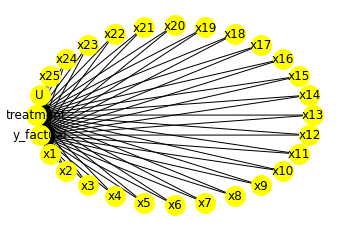

In [17]:
model.view_model()

### Identity
The identify step uses the causal diagram created from the model step and identifies all the causal relationships. This code prints out:

In [8]:
#Identify the causal effect
identified_estimand = model.identify_effect()
print(identified_estimand)

INFO:dowhy.causal_identifier:Common causes of treatment and outcome:['x21', 'x4', 'x23', 'x22', 'x25', 'x14', 'x5', 'x2', 'x15', 'x19', 'x18', 'x13', 'x6', 'x1', 'x9', 'x11', 'x3', 'x20', 'U', 'x12', 'x16', 'x7', 'x10', 'x17', 'x8', 'x24']


WARN: Do you want to continue by ignoring any unobserved confounders? (use proceed_when_unidentifiable=True to disable this prompt) [y/n]  y


INFO:dowhy.causal_identifier:Instrumental variables for treatment and outcome:[]


Estimand type: nonparametric-ate
### Estimand : 1
Estimand name: backdoor
Estimand expression:
     d                                                                        
────────────(Expectation(y_factual|x21,x4,x23,x22,x25,x14,x5,x2,x15,x19,x18,x1
d[treatment]                                                                  

                                                 
3,x6,x1,x9,x11,x3,x20,x12,x16,x7,x10,x17,x8,x24))
                                                 
Estimand assumption 1, Unconfoundedness: If U→{treatment} and U→y_factual then P(y_factual|treatment,x21,x4,x23,x22,x25,x14,x5,x2,x15,x19,x18,x13,x6,x1,x9,x11,x3,x20,x12,x16,x7,x10,x17,x8,x24,U) = P(y_factual|treatment,x21,x4,x23,x22,x25,x14,x5,x2,x15,x19,x18,x13,x6,x1,x9,x11,x3,x20,x12,x16,x7,x10,x17,x8,x24)
### Estimand : 2
Estimand name: iv
No such variable found!



Since we’re not trying to find 2 causal relationships (just trying to find the effect of intervention on outcome) estimand 2 is not found.

### Estimate
Using the estimand (the causal relationship identified) we can now estimate the strength of this causal relationship. There are many methods available to us (propensity-based-matching, additive noise modeling), but in this tutorial, we’ll stick to good ol’ fashioned linear regression.

In [15]:
# Estimate the causal effect and compare it with Average Treatment Effect
estimate = model.estimate_effect(identified_estimand, method_name="backdoor.linear_regression", test_significance=True)
print(estimate)
print(f"Causal Estimate is {estimate.value}" )
data_1 = data[data["treatment"]==1]
data_0 = data[data["treatment"]==0]
print(f"ATE: {np.mean(data_1['y_factual']) - np.mean(data_0['y_factual'])}")

INFO:dowhy.causal_estimator:INFO: Using Linear Regression Estimator
INFO:dowhy.causal_estimator:b: y_factual~treatment+x21+x4+x23+x22+x25+x14+x5+x2+x15+x19+x18+x13+x6+x1+x9+x11+x3+x20+x12+x16+x7+x10+x17+x8+x24


                            OLS Regression Results                            
Dep. Variable:              y_factual   R-squared:                       0.740
Model:                            OLS   Adj. R-squared:                  0.731
Method:                 Least Squares   F-statistic:                     78.91
Date:                Mon, 02 Nov 2020   Prob (F-statistic):          6.10e-191
Time:                        12:19:42   Log-Likelihood:                -1138.1
No. Observations:                 747   AIC:                             2330.
Df Residuals:                     720   BIC:                             2455.
Df Model:                          26                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          2.2206      0.448      4.957      0.0

As you can see, the ATE is pretty close to the Causal Estimate that we got. The ~4 is the difference in wellbeing of the premature babies that had care vs. those who didn’t. The number 4 doesn’t have much meaning semantically because it is the literal difference of the outcome between the two groups, and the outcome, in this case, was a combination of a variety of other factors. If you take a look back at the 5 cases that were printed out, the differences between the two are about 4.

### Refute
The refute steps tests the strength and validity of the causal effect found by the estimate step. There are a variety of different refutation methods, eg. Subset Validation (using only a subset of the data to estimate the causal effect) or Placebo Treatment (turning the treatment into a placebo and seeing its effect on the outcome (the placebo treatment refutation expects the causal effect to go down)) In this case, we’ll be adding an irrelevant common cause to test the strength of the causal relationship between the treatment and outcome. This is useful because it changes the causal model but not the relationship between y_factual and treatment.

In [10]:
refute_results=model.refute_estimate(identified_estimand, estimate,
        method_name="random_common_cause")
print(refute_results)

INFO:dowhy.causal_estimator:INFO: Using Linear Regression Estimator
INFO:dowhy.causal_estimator:b: y_factual~treatment+x21+x4+x23+x22+x25+x14+x5+x2+x15+x19+x18+x13+x6+x1+x9+x11+x3+x20+x12+x16+x7+x10+x17+x8+x24+w_random


                            OLS Regression Results                            
Dep. Variable:              y_factual   R-squared:                       0.741
Model:                            OLS   Adj. R-squared:                  0.731
Method:                 Least Squares   F-statistic:                     76.06
Date:                Mon, 02 Nov 2020   Prob (F-statistic):          2.95e-190
Time:                        12:17:43   Log-Likelihood:                -1137.5
No. Observations:                 747   AIC:                             2331.
Df Residuals:                     719   BIC:                             2460.
Df Model:                          27                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          2.2226      0.448      4.962      0.0

Adding a random common cause didn’t have much of an effect on the causal effect (as expected) and so we can be more assured of the strength of the causal relationship.